In [32]:
import matplotlib.pyplot as plt

In [29]:
from single_run import single_run

In [30]:
from run_functions import *
from agent_functions import *
from routing_networks import braess_augmented_network, braess_initial_network
from recommenders import heuristic_recommender, constant_recommender
from plot_functions import plot_run
import numpy as np

In [31]:
def calculate_alignment(q_table, recommendation, actions):
    argmax_q_table = np.argmax(q_table, axis=2)
    belief_alignment = (argmax_q_table == np.broadcast_to(np.arange(q_table.shape[2]), (q_table.shape[0], q_table.shape[1]))).mean(axis=0)
    recommendation_alignment = (recommendation == argmax_q_table[np.arange(q_table.shape[0]), recommendation]).mean()
    action_alignment = (recommendation==actions).mean()
    return belief_alignment, recommendation_alignment, action_alignment

run_vector_field


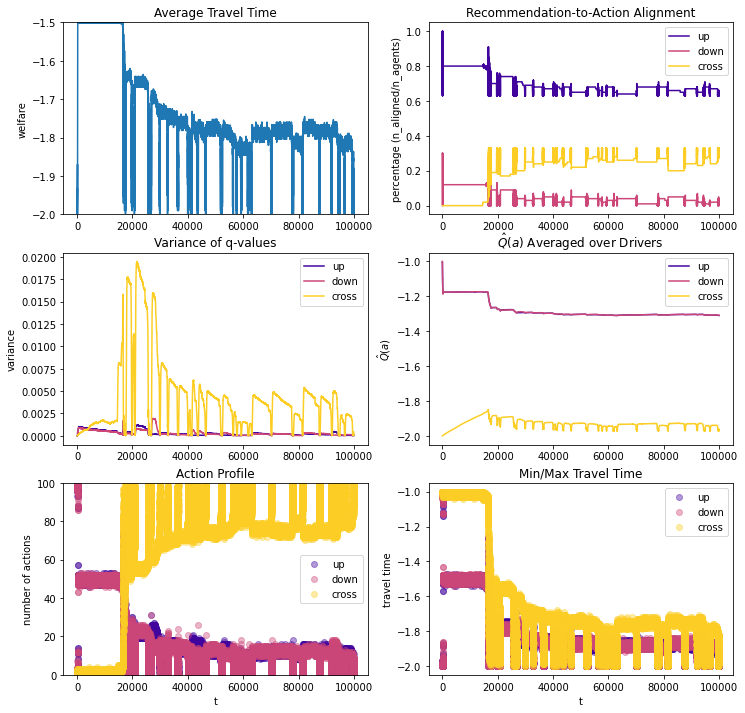

CPU times: user 1min 12s, sys: 836 ms, total: 1min 13s
Wall time: 1min 13s


In [140]:
%%time
N_AGENTS = 100
N_STATES = 3
N_ACTIONS = 3
N_ITER = 100000

EPSILON = 0.01
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.01

QINIT = np.array([-1, -1, -2])

Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)

vectors = []

for t in range(N_ITER):
    
#     S = naive_recommender(Q, N_AGENTS)
#     S = heuristic_recommender(Q, N_AGENTS)
#     S = aligned_heuristic_recommender(Q, N_AGENTS)
#     S = optimized_heuristic_recommender(Q, N_AGENTS, method="estimate", minimize=True)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, travel_time_per_route = braess_augmented_network(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)
    
    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            "groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            "alignment": alignment,
            "recommendation_alignment": recommendation_alignment,
            "action_alignment": action_alignment,
           }

NAME = f"run_vector_field"

plot_run(M, NAME, N_AGENTS, N_ACTIONS, N_ITER)

In [141]:
vectors = [(M[i+1]["nA"] - M[i]["nA"]) for i in range(N_ITER-1)]

In [142]:
x_0 = np.array([M[t]["nA"][0] for t in range(N_ITER-1)])
y_0 = np.array([M[t]["nA"][1] for t in range(N_ITER-1)])
z_0 = np.array([M[t]["nA"][2] for t in range(N_ITER-1)])

u = np.array([v[0] for v in vectors])
v = np.array([v[1] for v in vectors])
w = np.array([v[2] for v in vectors])

In [143]:
import pandas as pd

coords = ['x','y','z']
arrows = ['u','v','w']

def bin2number(x, bins):
    x = np.digitize(x, bins)
    arr = []
    for i in x:
        i-=1
        if i>len(bins):
            arr.append(bins[-1])
        else:
            arr.append(bins[i:i+2].mean())
    return np.array(arr)



def average_and_bin(points, diffs, bins=None):
    df_points = pd.DataFrame(points, columns=coords)
    df_arrows = pd.DataFrame(diffs, columns=arrows)

    df = pd.concat([df_points, df_arrows], axis=1)

    if bins is not None:
        for coord in coords:
            df[coord] = bin2number(df[coord], bins)


    averaged = df.groupby(coords).mean().reset_index()

    return averaged[coords].values, averaged[arrows].values

In [217]:
normal = np.ones(shape=(1,3)) #3d normal vector
normal = normal/np.sqrt((normal**2).sum())

In [218]:
y = np.array([0,0,1])  
y = y - np.dot(y, normal.T) * normal
y /= np.sqrt((y**2).sum())
y

array([[-0.40824829, -0.40824829,  0.81649658]])

In [219]:
x = np.cross(normal, y)

In [220]:
def project2d(A, x, y):
    return np.dot(A, x.T), np.dot(A, y.T)

In [221]:
points = np.vstack([x_0,y_0,z_0]).T

In [222]:
diffs = np.vstack([u,v,w]).T

In [223]:
bins = np.linspace(0,100,21)
pp, dd = average_and_bin(points, diffs, bins)

In [224]:
x_c = (0, 0, 100)
x_u = (100, 0, 0)
x_d = (0, 100, 0)

In [225]:
points_x, points_y = project2d(pp, x, y)
diffs_x, diffs_y = project2d(dd, x, y)

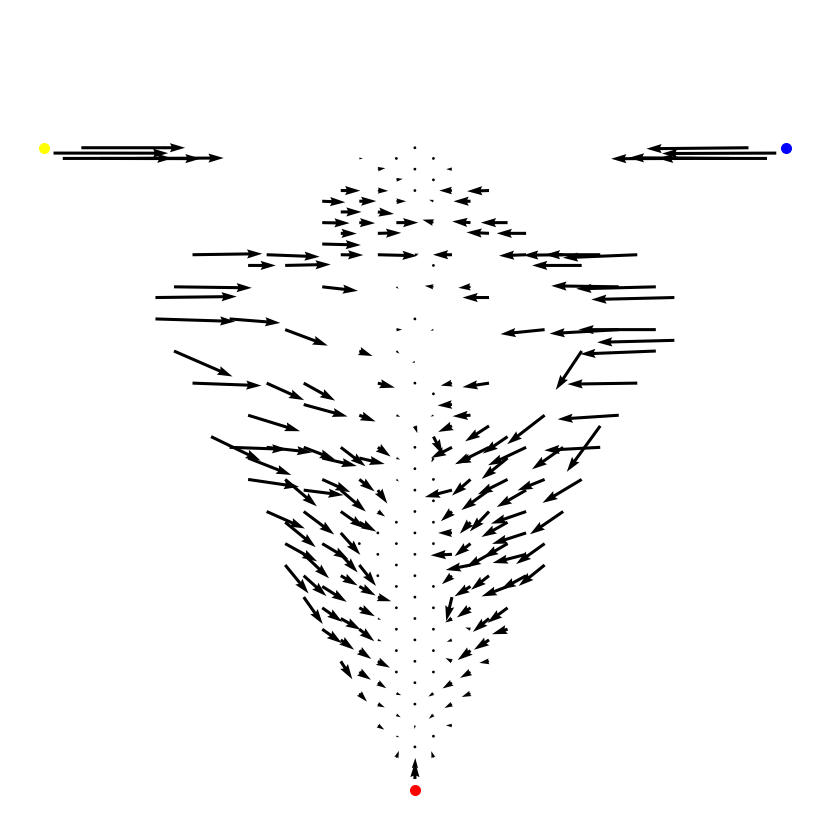

In [212]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.quiver(points_x, points_y, diffs_x, diffs_y, angles="xy", scale=1000)
plt.scatter(*project2d(np.array(x_c), x, y), color="red", s=100)
plt.scatter(*project2d(np.array(x_u), x, y), color="yellow", s=100)
plt.scatter(*project2d(np.array(x_d), x, y), color="blue", s=100)
# plt.ylim(0, )
# plt.xlim(0, 100)
plt.axis("off")
plt.axis("square")
plt.savefig("braess_vector_field.pdf")

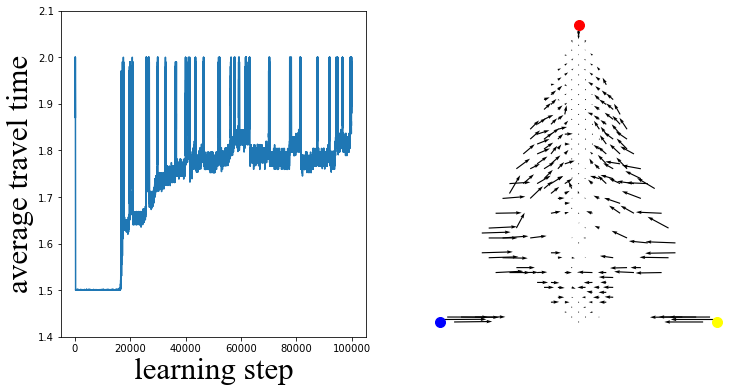

In [236]:
fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(12, 6))

ax.plot([-M[t]["R"].mean() for t in range(N_ITER)], color=u'#1f77b4', label="half-half")
ax.set_ylim((1.4, 2.1))
ax.set_xlabel('learning step', **{"fontname": "Times New Roman", "fontsize": "31"})
ax.set_ylabel('average travel time', **{"fontname": "Times New Roman", "fontsize": "31"})

ax2.quiver(points_x, points_y, diffs_x, diffs_y, angles="xy", scale=1000)
ax2.scatter(*project2d(np.array(x_c), x, y), color="red", s=100)
ax2.scatter(*project2d(np.array(x_u), x, y), color="yellow", s=100)
ax2.scatter(*project2d(np.array(x_d), x, y), color="blue", s=100)
# ax2.set_xlabel('vector field', **{"fontname": "Times New Roman", "fontsize": "31"})

ax2.axis("off")
# ax2.axis("square")
plt.savefig("braess_example_with_vectorfield.png")